# Callin Switzer
### 12 Dec 2018 -- Initial commit
___
### - Train Dense, Feedforward Neural Network with Keras
### - Use data that was generated in Python

___

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.ticker import ScalarFormatter
import os
import pandas as pd
import time
from datetime import datetime
import sys
import seaborn as sns
import scipy.io
import subprocess
import winsound
import pickle
import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
print(sys.version, "\n")
now = datetime.now()
print("last run on " + str(now))

# define directories
baseDir = os.getcwd()
dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\Figs'
dataOutput = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput'
savedModels = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels'
dataDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\data'
if not os.path.exists(figDir):
    os.mkdir(figDir)

if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)


C:\Users\calli\Anaconda3\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)] 

last run on 2019-10-16 10:53:15.923102


In [2]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

Using TensorFlow backend.


# Make training and test set

In [3]:
# concatenate all files (only need to do this once)
# it takes a few minutes
all_files = glob.glob(os.path.join(dataDir, "*.csv"))     
df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)

# check for duplicates
concatenated_df.drop_duplicates(inplace=True)
concatenated_df.shape

print(concatenated_df.shape)
concatenated_df.tail()

# save to hdf5
concatenated_df.to_hdf(os.path.join(dataOutput, "concatenatedRandomICs.h5"), key = "data")

(1000000, 19)


In [4]:
# read in data
trainDF = pd.read_hdf(os.path.join(dataOutput, "concatenatedRandomICs.h5"), key = "data")

In [5]:
# double check for repeats!
np.sum(trainDF.iloc[:, [16,17,18]].duplicated()) # 0 means no repeats

0

In [6]:
print(trainDF.shape)
trainDF.head()

(1000000, 19)


,x0,xf,xd0,xdf,y0,yf,yd0,ydf,theta0,thetaf,thetad0,thetadf,phi0,phif,phid0,phidf,F,alpha,tau0
0,0.0,-860.538764,-50122.042406,-37099.512049,0.0,1864.077658,112333.095649,78407.466199,1.124204,1.775187,-240.317688,-398.977940,1.676109,1.137340,223.908457,-460.120574,365925.417230,4.308596,905969.160686
1,0.0,1663.999327,98162.039550,70772.904894,0.0,-1578.437127,-91951.892590,-68471.287625,2.693406,4.812711,-200.894863,1400.049194,5.327012,8.650992,-22.632197,1415.053045,301963.993342,1.157471,-836862.125114
2,0.0,-2112.906211,-128322.658782,-88483.199912,0.0,1827.677469,108010.493730,78786.893601,0.268087,1.672884,-76.923640,463.565758,5.398761,6.408854,233.275667,427.271735,442563.311276,6.082598,-128736.343362
3,0.0,-1111.053471,-61945.461511,-51111.250941,0.0,-2178.117332,-134603.694224,-90142.071404,1.454196,5.328020,-143.582522,1517.591974,3.281781,7.010763,-243.190037,1546.588052,179536.991219,4.832508,567528.919560
4,0.0,-729.739726,-39285.280174,-34179.352246,0.0,-1031.910887,-56601.382912,-46818.328690,0.353609,-3.623116,-228.575046,389.104159,4.769991,-0.295224,-76.699950,321.156438,130307.280323,0.590567,684706.884762


In [7]:
# rename columns to be consistent with other code
trainDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "xf" : "x_99", "yf" : "y_99", "phif" : "phi_99", "thetaf" : "theta_99", 
                        "xd0" : "x_dot_0", "yd0" : "y_dot_0", "phid0" : "phi_dot_0", "thetad0": "theta_dot_0", 
                        "xdf" : "x_dot_99", "ydf": "y_dot_99", "phidf": "phi_dot_99", "thetadf": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

In [8]:
# convert angles to sine and cosine
# cosx = np.cos(angle)
# sinx = np.sin(angle)

# # print(angle, np.arctan2(sinx, cosx))

# trainDF["cos_phi_0"] = np.cos(trainDF.phi_0)
# trainDF["sin_phi_0"] = np.sin(trainDF.phi_0)
# trainDF["cos_phi_99"] = np.cos(trainDF.phi_99)
# trainDF["sin_phi_99"] = np.sin(trainDF.phi_99)

# trainDF["sin_theta_0"] = np.sin(trainDF.theta_0)
# trainDF["cos_theta_0"] = np.cos(trainDF.theta_0)
# trainDF["sin_theta_99"] = np.sin(trainDF.theta_99)
# trainDF["cos_theta_99"] = np.cos(trainDF.theta_99)

# convert to fx and fy
trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)


In [9]:
# make dataset
X = trainDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = trainDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

In [10]:
X.head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,1.676109,1.124204,-860.538764,1864.077658,1.137340,1.775187,-50122.042406,112333.095649,223.908457,-240.317688
1,5.327012,2.693406,1663.999327,-1578.437127,8.650992,4.812711,98162.039550,-91951.892590,-22.632197,-200.894863
2,5.398761,0.268087,-2112.906211,1827.677469,6.408854,1.672884,-128322.658782,108010.493730,233.275667,-76.923640
3,3.281781,1.454196,-1111.053471,-2178.117332,7.010763,5.328020,-61945.461511,-134603.694224,-243.190037,-143.582522
4,4.769991,0.353609,-729.739726,-1031.910887,-0.295224,-3.623116,-39285.280174,-56601.382912,-76.699950,-228.575046


In [11]:
Y.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,-143775.519045,-336496.673235,905969.160686,-37099.512049,78407.466199,-460.120574,-398.977940
1,121285.802738,276535.725231,-836862.125114,70772.904894,-68471.287625,1415.053045,1400.049194
2,433689.765168,-88178.637303,-128736.343362,-88483.199912,78786.893601,427.271735,463.565758
3,21514.002933,-178243.313742,567528.919560,-51111.250941,-90142.071404,1546.588052,1517.591974
4,108236.510499,72559.252341,684706.884762,-34179.352246,-46818.328690,321.156438,389.104159


In [12]:
# test train split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state = 123)

In [13]:
# scale data 
scalerX = MinMaxScaler([-0.5, 0.5])  
scalerY = MinMaxScaler([-0.5, 0.5])  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xtest_scaled = scalerX.transform(Xtest)
Ytest_scaled = scalerY.transform(Ytest)

In [14]:
pd.DataFrame(Xtrain_scaled, columns = X.columns).head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,-0.404116,-0.008547,-0.104603,-0.296281,0.009714,0.034601,-0.087175,-0.281795,0.345508,-0.162392
1,0.056802,0.400122,0.193854,-0.277157,0.035039,0.048711,0.170873,-0.256671,-0.102233,-0.262934
2,0.398664,0.246730,-0.360971,-0.067285,0.030117,0.028668,-0.344482,-0.056832,-0.166634,0.182845
3,-0.383884,-0.443625,-0.402125,0.358309,0.026562,0.030448,-0.399042,0.351178,-0.211649,0.404179
4,0.310303,0.474445,-0.114387,0.063867,-0.283210,-0.277623,-0.101098,0.052708,-0.098453,0.310559


In [15]:
pd.DataFrame(Xtrain, columns = X.columns).head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
720025,0.602460,3.087890,-509.331547,-1442.314993,0.413975,3.739040,-26152.598918,-84538.202602,172.753398,-81.195467
123815,3.498484,5.655627,944.184558,-1349.201413,3.842831,5.640656,51261.809337,-77001.113032,-51.116400,-131.466402
717911,5.646466,4.691841,-1757.875640,-327.373192,3.176457,2.939391,-103344.604040,-17049.432183,-83.317009,91.422375
691720,0.729579,0.354218,-1958.298929,1744.765648,2.695102,3.179329,-119712.414006,105353.422481,-105.824072,202.088671
951608,5.091274,6.122615,-556.980219,311.182068,-39.246926,-38.340463,-30329.617391,15812.558650,-49.226506,155.278835


In [16]:
# save scalers, to be used on test set
scalerfileX = 'scalerX.pkl'
pickle.dump(scalerX, open(os.path.join(dataOutput, scalerfileX), 'wb'))

scalerfileY = 'scalerY.pkl'
pickle.dump(scalerY, open(os.path.join(dataOutput, scalerfileY), 'wb'))

# Keras models

In [17]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

In [18]:
K.clear_session()

In [19]:
# create network
def create_network(optimizer = 'rmsprop', 
                    numUnits = [400, 16], 
                    weightRegularization = 0.0, 
                    dropout_rate=0.1):
    
    '''
    Create a feed forward network.  Assumes Xtrain & Ytrain have been created and scaled
    
    Params: 
    optimizer (str): choice of optimizer
    numUnits (list): number of units in each hidden
    weightRegularization (float): between 0 and 1
    dropout_rate (float): between 0 and 1
    
    '''
    K.clear_session()
    inputs = Input(shape=(Xtrain_scaled.shape[1],))    
    
    # add layers
    for ii in np.arange(0, len(numUnits)):
        if ii >= 1: 
            x = Dense(numUnits[ii], activation='tanh', 
                      kernel_regularizer=regularizers.l1(weightRegularization))(x)

        else: 
            x = Dense(numUnits[ii], activation='tanh')(inputs)


        # add dropout
        if dropout_rate > 0: 
            x = Dropout(dropout_rate)(x)
    
    predictions = Dense(Ytrain_scaled.shape[1], activation='linear')(x)

    # create model
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])

    return(model)

In [20]:
modelParams = {"optimizer": "rmsprop", 
              "dropout_rate" : 0.0, 
               "numUnits": [400, 400, 400, 16],
               "weightRegularization": 0
              }


model = create_network(**modelParams)

modelName = ''.join('{}_{}__'.format(key[0:3].capitalize(), val) for  key, val in modelParams.items()).replace("[", "").replace("]", "").replace(", ", "_")[0:-2]
modelName  = modelName +  "_" + str(datetime.now())[0:-7].replace("-", "_").replace(" ", "__").replace(":", "_")
print(modelName)

model.summary()

Opt_rmsprop__Dro_0.0__Num_400_400_400_16__Wei_0_2019_10_16__10_57_40
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               4400      
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                6416      
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 119       
Total params: 331,735
Trainable params: 331,735
Non-trainable params: 0
_

In [21]:
#model.get_config()
earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=150, 
                          verbose=1, mode='auto', min_delta = 0.000001)

In [70]:
# fit model without regularization
stt = time.time()
history = model.fit(Xtrain_scaled, Ytrain_scaled, epochs = 500, verbose = 2, 
                        batch_size=2**10, callbacks = [earlystop], validation_split = 0.3)
winsound.PlaySound("*", winsound.SND_ALIAS)
endd = time.time() - stt
print(endd)

Train on 560000 samples, validate on 240000 samples
Epoch 1/500
 - 2s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 2/500
 - 3s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 3/500
 - 2s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 4/500
 - 2s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 5/500
 - 2s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 6/500
 - 2s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 7/500
 - 3s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 8/500
 - 3s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 9/500
 - 3s - loss: 0.0040 - m

In [71]:
history.history['val_loss'][-1]# MSE for final epoch testing
# why are val MSE vs. loss different????  answer : I think loss incorporates regularization. 

0.004248727219551802

In [72]:
history.history['val_mean_squared_error'][-1] # it is the same when there is no regularization

0.004248727219551802

In [73]:
history.history['loss'][-1]# MSE for final epoch training

0.0039028648239161287

In [74]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]


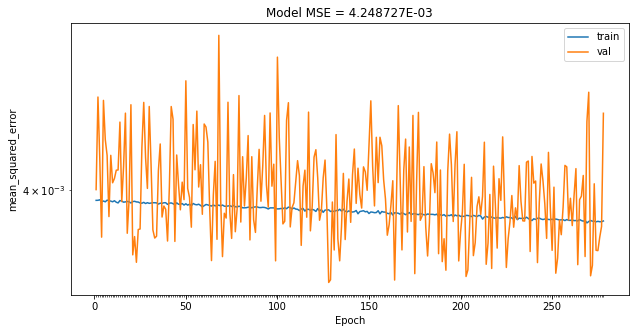

In [75]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE = '+ str(format_e(model_history.history['val_mean_squared_error'][-1])))
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),
                   len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + ".png"), dpi = 120, bbox_inches='tight')
    
    plt.show()
    
plot_model_history(history, saveFig=True)

In [76]:
# save model
model.save(os.path.join(savedModels,  modelName + '.h5'))

# save scaler with same name as model
scalerfileX = modelName + '_scalerX.pkl'
pickle.dump(scalerX, open(os.path.join(dataOutput, scalerfileX), 'wb'))

scalerfileY = modelName + '_scalerY.pkl'
pickle.dump(scalerY, open(os.path.join(dataOutput, scalerfileY), 'wb'))

In [77]:
# save weights
wts = model.get_weights().copy()

wtsFile = modelName + '_wts.pkl'
pickle.dump(wts, open(os.path.join(dataOutput, wtsFile), 'wb'))

In [78]:
# read file back in 
wt2 = pickle.load(open(os.path.join(dataOutput, wtsFile), 'rb'))

In [79]:
# END
os.path.join(dataOutput, wtsFile)

'D:\\Dropbox\\AcademiaDropbox\\mothMachineLearning_dataAndFigs\\DataOutput\\Opt_rmsprop__Dro_0.0__Num_400_400_400_16__Wei_0_2019_10_16__10_57_40_wts.pkl'